In [33]:
# default_exp cluster_ions

## Module Tests

In [34]:
import alphaquant.cluster.cluster_ions as aqclust
import alphaquant.cluster.cluster_utils as aqclustutils

In [35]:
#hide

def test_exchange_cluster_idxs():
    assert aqclustutils.exchange_cluster_idxs([1,2,1,2,2,2]) == [1,0,1,0,0,0]

test_exchange_cluster_idxs()

In [36]:
import uuid
import alphaquant.diffquant.background_distributions as aqbg
import alphaquant.benchm.benchmarking as aqbm
import alphaquant.diffquant.diff_analysis as aqdiff
import alphaquant.diffquant.diffutils as aqutils
import itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def simulate_normed_input():

    sample2cond_df = pd.DataFrame({'sample' : ['A1', 'A2', 'A3', 'B1', 'B2', 'B3','B4', 'B5', 'B6', 'B7', 'B8', 'B9','B10', 'B11', 'B12'],
    'condition' : ['A', 'A', 'A', 'B', 'B', 'B','B', 'B', 'B','B', 'B', 'B','B', 'B', 'B']})
    unnormed_df = aqbm.generate_random_input(10000, sample2cond_df,simulate_nas=True)
    df_c1, df_c2 = get_c1_c2_dfs(unnormed_df, sample2cond_df, ["A", "B"])
    p2z = {}
    normed_c1 = aqbg.ConditionBackgrounds(df_c1, p2z)
    normed_c2 = aqbg.ConditionBackgrounds(df_c2, p2z)
    return normed_c1, normed_c2

def get_c1_c2_dfs(unnormed_df, labelmap_df, condpair, minrep = 2):
    c1_samples = labelmap_df[labelmap_df["condition"]== condpair[0]]
    c2_samples = labelmap_df[labelmap_df["condition"]== condpair[1]]
    df_c1 = unnormed_df.loc[:, c1_samples["sample"]].dropna(thresh=minrep, axis=0)
    df_c2 = unnormed_df.loc[:, c2_samples["sample"]].dropna(thresh=minrep, axis=0)

    return df_c1, df_c2

def generate_diffions():
    normed_c1, normed_c2 = simulate_normed_input()
    ion2diffDist = {}
    p2z = {}
    diffions = []
    ions_to_check = normed_c1.ion2nonNanvals.keys() & normed_c2.ion2nonNanvals.keys()
    for idx, ion in enumerate(ions_to_check):
        if not (("pep12_" in ion) | ("pep23_" in ion)):
            continue

        vals1 = normed_c1.ion2nonNanvals.get(ion)
        vals2 = normed_c2.ion2nonNanvals.get(ion)
        bg1 = normed_c1.ion2background.get(ion)
        bg2 = normed_c2.ion2background.get(ion)
        diffDist = aqbg.get_subtracted_bg(ion2diffDist, bg1, bg2,p2z)
        diffIon = aqdiff.DifferentialIon(vals1, vals2, diffDist, ion, outlier_correction = False)
        diffions.append(diffIon)
        #if idx>100:
         #   break
    
    return diffions, normed_c1, normed_c2


def add_shifts_to_diffions(ion2shift,diffions, normed_c1, normed_c2):
    ion2diffdist = {}
    ionname2diffion = {}
    for ion in diffions:
        shift = ion2shift.get(ion.name)
        vals1 = normed_c1.ion2nonNanvals.get(ion.name)
        vals2 = normed_c2.ion2nonNanvals.get(ion.name)
        bg1 = normed_c1.ion2background.get(ion.name)
        bg2 = normed_c2.ion2background.get(ion.name)

        ion.fc = ion.fc+shift
        if shift>0:
            vals2 = vals2+shift
            normed_c2.ion2nonNanvals[ion.name] = vals2
            normed_c2.ion2allvals[ion.name] = np.array([x + shift for x in  normed_c2.ion2allvals[ion.name] if x!=0])
            
        if shift<0:
            vals1 = vals1+shift
            normed_c1.ion2nonNanvals[ion.name] = vals1
            normed_c1.ion2allvals[ion.name] =  np.array([x + shift for x in  normed_c1.ion2allvals[ion.name] if x!=0])

        diffDist = aqbg.get_subtracted_bg(ion2diffdist, bg1, bg2, {})

        diffIon = aqdiff.DifferentialIon(vals1, vals2, diffDist, ion.name, outlier_correction = False)
        ionname2diffion[ion.name] = diffIon
        #if idx>100:
         #   break

    return ionname2diffion
    


import alphaquant.diffquant.diffutils as aqutils

def test_tree_construction():

    diffions, normed_c1, normed_c2 = generate_diffions()
    regex_patterns = [[("(.*_LVL0.*_LVL1.*_LVL2.*_LVL3)(_mod[0-1])","frgion"), ("(.*_LVL0.*_LVL1.*_LVL2.*_LVL3)(_mod[2-3])", "ms1_isotopes")], [("(.*_LVL0.*_LVL1.*_LVL2)(.*_LVL3)", "mod_seq_charge")], [("(.*_LVL0.*_LVL1)(.*_LVL2)", "mod_seq")], 
    [("(.*)(.*_LVL0.*_LVL1.*)", "seq")]]
    node = aqclust.create_hierarchical_ion_grouping(regex_patterns,"testgene",diffions)
    #print(anytree.RenderTree(node))
    #dotexporter.UniqueDotExporter(node).to_picture("tmp.png")
    print(f'diffions {[x.name for x in diffions]}')
    typefilter = aqclust.TypeFilter()

    deedpair2doublediffdist = {}
    dpair2diffdist = {}
    p2z = {}
    aqbm.add_perturbations_to_proteins([node])
    ion2shift = {x.name:x.applied_shift for x in node.leaves}
    ionname2diffion = add_shifts_to_diffions(ion2shift, diffions, normed_c1, normed_c2)
    node_clust = aqclust.cluster_along_specified_levels(typefilter,node,ionname2diffion, normed_c1, normed_c2,dpair2diffdist,p2z, deedpair2doublediffdist, pval_threshold_basis=0.05, fcfc_threshold=0, take_median_ion=False)
    aqbm.count_correctly_excluded([node], [node_clust])
    #logging.info(anytree.RenderTree(node_clust))
    #print(anytree.RenderTree(node_clust))



test_tree_construction()


4709
t_ion2nonan_sw 0.00898599624633789
t_intensity_selection 0.1514899730682373
t_ion2nonan_sw 0.008934736251831055
t_intensity_selection 0.40739989280700684
diffions ['pep23_LVL0_mod0_LVL1_mod0_LVL2_mod2_LVL3_mod0', 'pep23_LVL0_mod0_LVL1_mod0_LVL2_mod1_LVL3_mod0', 'pep12_LVL0_mod0_LVL1_mod0_LVL2_mod2_LVL3_mod0', 'pep23_LVL0_mod0_LVL1_mod0_LVL2_mod0_LVL3_mod0', 'pep12_LVL0_mod0_LVL1_mod0_LVL2_mod0_LVL3_mod0', 'pep23_LVL0_mod0_LVL1_mod0_LVL2_mod3_LVL3_mod0', 'pep12_LVL0_mod0_LVL1_mod0_LVL2_mod1_LVL3_mod0']
level frgion
accuracy:0.0	precision:[0. 0.]	recall[0. 0.]	fscore[0. 0.]


/Users/constantin/opt/anaconda3/envs/alphaquant/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/constantin/opt/anaconda3/envs/alphaquant/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [37]:
import numpy as np

my_generator = (x for x in range(5))
my_array = np.fromiter(my_generator, dtype='float')
print(my_array)

[0. 1. 2. 3. 4.]


('S1', 'S2')
t_ion2nonan_sw 0.0474700927734375
t_intensity_selection 0.9016718864440918
t_ion2nonan_sw 0.048877716064453125
t_intensity_selection 0.8897809982299805


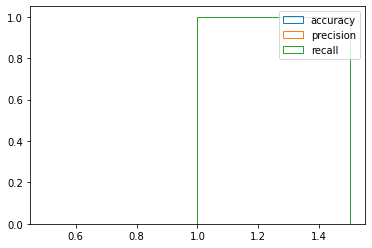

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [43]:
import anytree
import sklearn.metrics
import random
import math


def select_shifts_for_ions(diffions):
    ion2shift = {}
    num_shifted= 0
    for diffion in diffions:
        perturb = np.random.uniform(0, 1) < 0.3 #randomly select ~30% of the samples for perturbation
        if perturb:
            applied_shift = random.sample([-1, 1],1)[0]
            ion2shift[diffion.name] = applied_shift
            num_shifted+=1
        else:
            ion2shift[diffion.name] = 0
    return ion2shift, num_shifted

def compare_clustered_and_shifted(ion2shift, ion2clust):
    is_shifted_vec = []
    clust_nonzero_vec = []
    for ion in ion2shift:
        is_shifted = ion2shift.get(ion)!=0
        clust_nonzero = ion2clust.get(ion)!=0
        if (not is_shifted) and (not clust_nonzero):
            continue
        clust_nonzero_vec.append(clust_nonzero)
        is_shifted_vec.append(is_shifted)
    
    
    accuracy = sklearn.metrics.accuracy_score(y_true = is_shifted_vec, y_pred = clust_nonzero_vec)
    recall = sklearn.metrics.recall_score(y_true=is_shifted_vec, y_pred = clust_nonzero_vec)
    precision = sklearn.metrics.precision_score(y_true=is_shifted_vec, y_pred = clust_nonzero_vec)
    length = len(clust_nonzero_vec)
    #print(f"accuracy is {accuracy}")
    #print(f"precision {precision}\trecall {recall}")

    return accuracy, precision, recall, length



def check_correct_clustering(diffions, normed_c1, normed_c2):
    diffions_grouped = [[x] for x in diffions]
    ion2shift, num_shifted = select_shifts_for_ions(diffions)
    if num_shifted==0 or num_shifted>(math.ceil(len(diffions)/2-1)):
        return None
    ionname2diffion = add_shifts_to_diffions(ion2shift, diffions, normed_c1, normed_c2)
    fcs_ions = [x.fc for x in ionname2diffion.values()]
    type_node = anytree.Node("root")
    for diffion in ionname2diffion.values():
        anytree.Node(diffion.name, parent=type_node)
    childnode2clust = aqclust.find_fold_change_clusters(type_node, diffions_grouped, normed_c1, normed_c2, {}, {}, {},0.05, 0,False) #the clustering is performed on the child nodes
    chilnodename2clust = {x.name : y for x,y in childnode2clust}
    accuracy, precision, recall, length = compare_clustered_and_shifted(ion2shift, chilnodename2clust)
    
    clusts = {x for x in chilnodename2clust.values()}
    num_clusts = len(clusts)
    if num_clusts>2:
        return None

    return accuracy, precision, recall, length

diffions_real, normed_c1_real, normed_c2_real = aqbm.load_real_example_ions(input_file="../test_data/unit_tests/cluster_ions/filtered_fragions.aq_reformat.tsv",
samplemap_file="../test_data/unit_tests/cluster_ions/samples.map.tsv",num_ions=1000)

diffions_subsetted = [diffions_real[i:i + 10] for i in range(0, len(diffions_real), 10)]
accuracies = []
precisions = []
recalls = []
for diffions in diffions_subsetted:
    try:
        accuracy,precison,recall, length = check_correct_clustering(diffions, normed_c1_real, normed_c2_real)
    except:
        continue
    accuracies.append(accuracy)
    precisions.append(precison)
    recalls.append(recall)

plt.hist(accuracies, cumulative=True, density=True, histtype='step', label='accuracy')
plt.hist(precisions,cumulative=True, density=True, histtype='step', label='precision')
plt.hist(recalls,cumulative=True, density=True, histtype='step', label='recall')
plt.legend()
plt.show()
print(recalls)
num_total_recalls = sum([x==1 for x in recalls])
assert num_total_recalls == len(recalls)
